<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


In [ ]:
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import cv2
from skimage import io
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "dark", 
        color_codes = True,
        font_scale = 1.5)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

### Reading images from datasets

In [ ]:
from ipynb.fs.full.GradProject_NB1 import read_training_data

In [ ]:
training_data, label_dict = read_training_data()
print(" Dataset dimensions:", training_data.shape)

	- Fetching label 'airplanes'
	- Fetching label 'bear'
	- Fetching label 'blimp'
		- Gray image ('blimp_0022.jpg') was loaded, converting to RGB
	- Fetching label 'comet'
		- Gray image ('comet_0006.jpg') was loaded, converting to RGB
		- Gray image ('comet_0011.jpg') was loaded, converting to RGB
		- Gray image ('comet_0013.jpg') was loaded, converting to RGB
		- Gray image ('comet_0021.jpg') was loaded, converting to RGB
		- Gray image ('comet_0036.jpg') was loaded, converting to RGB
		- Gray image ('comet_0038.jpg') was loaded, converting to RGB
		- Gray image ('comet_0041.jpg') was loaded, converting to RGB
		- Gray image ('comet_0049.jpg') was loaded, converting to RGB
		- Gray image ('comet_0052.jpg') was loaded, converting to RGB
		- Gray image ('comet_0053.jpg') was loaded, converting to RGB
		- Gray image ('comet_0057.jpg') was loaded, converting to RGB
		- Gray image ('comet_0058.jpg') was loaded, converting to RGB
	- Fetching label 'crab'
		- Gray image ('crab_0045.jpg') was

<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [ ]:
def show(image):
    io.imshow(image)

### Presentation of dataset

The learning set consists of a total of 1,501 images, of 20 different types and of possibly different sizes (i.e.,numbers of pixels).  Each image is represented as 3-d array with the first two dimensions corresponding tothe row and column pixels and third dimension to the color.

Below is three of the represented categories displayed:

<Figure size 1296x576 with 0 Axes>

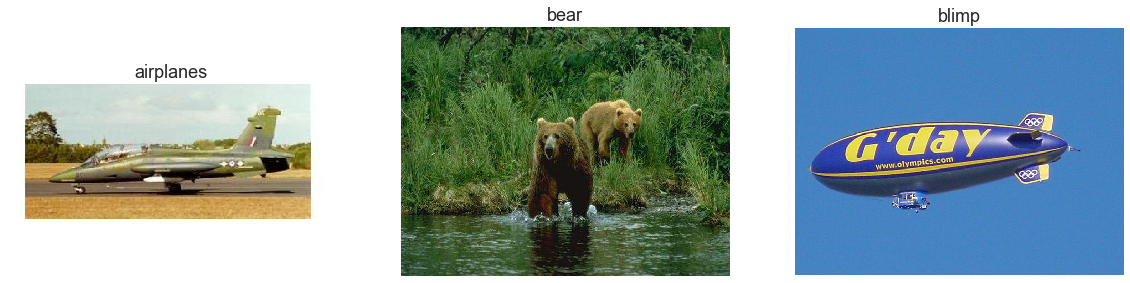

In [ ]:
# Displaying the three images from the first three categories in the training set
image_by_label = training_data.groupby("Label").agg({"Image": lambda x: list(x[0])})
image_by_label["Image"] = image_by_label["Image"].apply(np.array)
img1, img2, img3 = image_by_label["Image"].iloc[0], image_by_label["Image"].iloc[1], image_by_label["Image"].iloc[2]
[label1, label2, label3] = image_by_label.index[0:3]

# Plotting images
plt.figure(figsize=(18,8))
f, axes = plt.subplots(figsize=(20,10), ncols=3, nrows=1)

axes[0].imshow(img1)
axes[1].imshow(img2)
axes[2].imshow(img3)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].title.set_text(label_dict[label1])
axes[1].title.set_text(label_dict[label2])
axes[2].title.set_text(label_dict[label3]);

#### Class frequencies

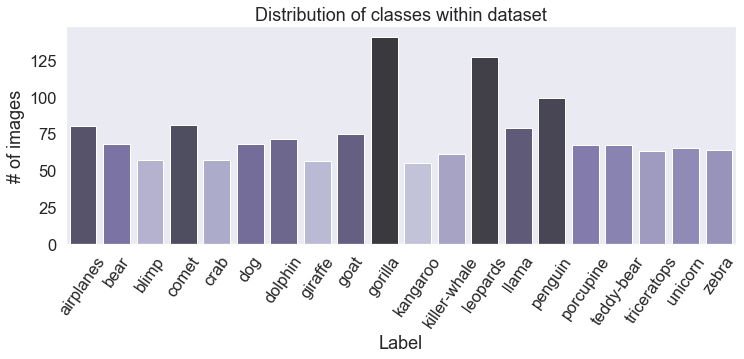

In [ ]:
plt.figure(figsize=(12,4))

labels = training_data.groupby("Label")["Image"].count()

pal = sns.color_palette("Purples_d", len(labels))
rank = labels.argsort().argsort()

ax = sns.barplot(x=[label_dict[label] for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within dataset")
plt.ylabel("# of images")
plt.xlabel("Label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);

The distribution is quite balanced, but there are some classes that are more represented than others, e.g. *Gorilla* and *Leopards*. If this becomes an issue, one might consider to down-sample the training set.

#### Graphical summaries of the sizes of the images in addition to pixel intensities

<Figure size 1080x360 with 0 Axes>

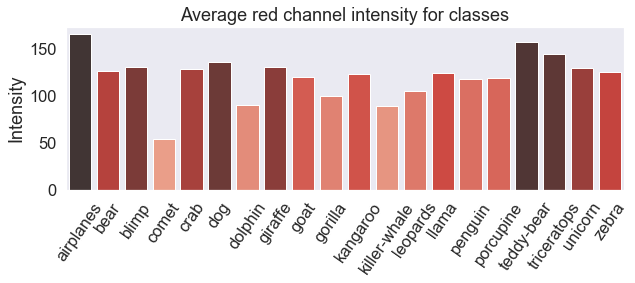

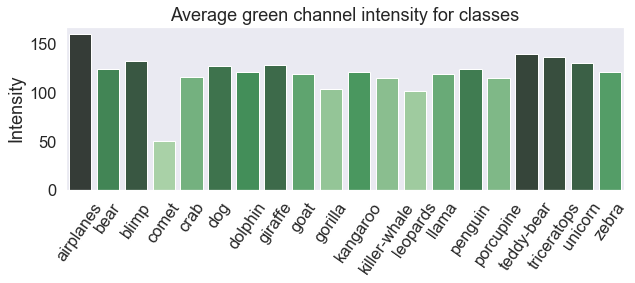

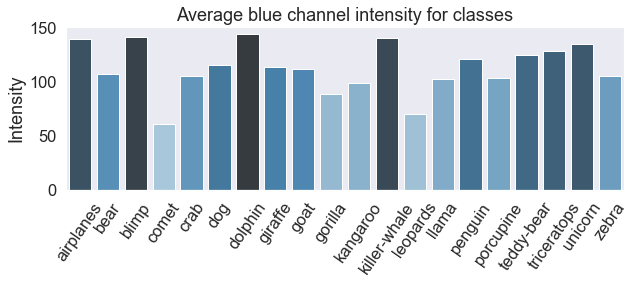

In [115]:
plt.figure(figsize=(15,5))
def calculate_channel_average(img, channel):
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

# Calculating channel average over all labels
red_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="R") for img in s])}).reset_index()
green_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="G") for img in s])}).reset_index()
blue_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="B") for img in s])}).reset_index()

def plot_channel_intensity_barplot(df, channel):
    # Plotting individual plots for channel intensities
    title_dict = {"r": "red", "g": "green", "b": "blue"}
    palet_dict = {"r": "Reds_d", "g": "Greens_d", "b": "Blues_d"}
    plt.figure(figsize=(10,3))

    values = df["Image"].values
    pal = sns.color_palette(palet_dict[channel], len(values))
    rank = values.argsort().argsort()
    ax = sns.barplot(x=[label_dict[label] for label in df["Label"]], y=values, palette=np.array(pal[::-1])[rank])
    
    plt.ylabel("Intensity")
    plt.title(f"Average {title_dict[channel]} channel intensity for classes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=55)

plot_channel_intensity_barplot(red_channel_average, "r")
plot_channel_intensity_barplot(green_channel_average, "g")
plot_channel_intensity_barplot(blue_channel_average, "b");

#### Plotting all channel distribtions together

In [116]:
def set_type_array(channel, df):
    
    df["type"] = [channel for _ in range(len(df))]

set_type_array("red", red_channel_average)
set_type_array("green", green_channel_average)
set_type_array("blue", blue_channel_average)

channel_averages = pd.concat([red_channel_average, green_channel_average, blue_channel_average])

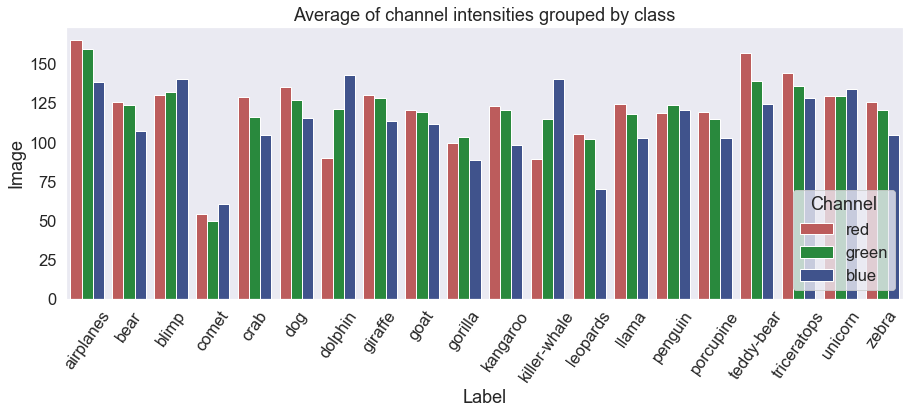

In [117]:
plt.figure(figsize=(15,5))

colors = [[0.8, 0.3, 0.3], [0.1, 0.6, 0.2], [0.2, 0.3, 0.6] ]

ax = sns.barplot(x=[label_dict[label] for label in channel_averages["Label"]], y="Image", hue="type", data=channel_averages, palette=colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);
plt.xlabel("Label")
plt.title("Average of channel intensities grouped by class")
ax.legend(title="Channel",loc="lower right");

#### Distribution of image sizes

Plotting the distribution of image sizes (number of values in a image-vector: $height*width*3$)

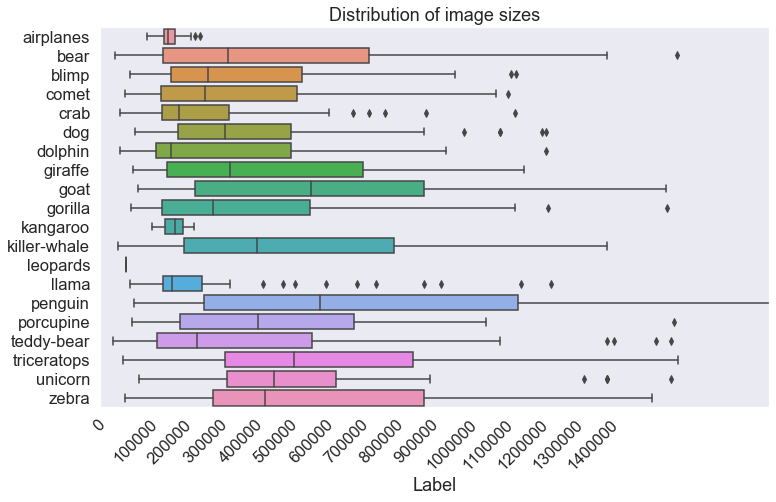

In [ ]:
plt.figure(figsize=(12,7))

training_data["size"] = training_data["Image"].apply(np.size)

ax = sns.boxplot(y=[label_dict[label] for label in training_data["Label"]], x="size", data=training_data, orient="h")
plt.title("Distribution of image sizes")
plt.xticks(np.arange(0, 1900000, 200000), rotation=45)
plt.xlim(0, 1900000)
plt.ylabel("Label");
plt.ylabel("Size");

We see that the distribution of image sizes among the different classes appear to be different. Many of the distributions stretches over similar areas, especially between 300,000 and 700,000. A couple of the categories such as; `airplanes`, `kangaroo` and `leopards`, have very small distributions, which indicates that size might be a good feature. 

In [119]:
training_data[training_data["Label"]==12]["size"].describe()

count      127.0
mean     73728.0
std          0.0
min      73728.0
25%      73728.0
50%      73728.0
75%      73728.0
max      73728.0
Name: size, dtype: float64

### Preprocessing

In [120]:
def get_trimmed_image(image):
    """
    Returns image without white border if such border exists.
    If not, returns original image
    """
    imagePIL = Image.fromarray(np.array(image))
    bg = Image.new(imagePIL.mode, imagePIL.size, imagePIL.getpixel((0,0)))
    diff = ImageChops.difference(imagePIL, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        trimmed_img = imagePIL.crop(bbox)
        return np.array(trimmed_img)
    return image

In [121]:
# Trim every image 
training_data['Image'] = training_data['Image'].apply(get_trimmed_image)

Rescaling to h: 316.43171219187207, w: 415.8789563762299


<Figure size 1296x576 with 0 Axes>

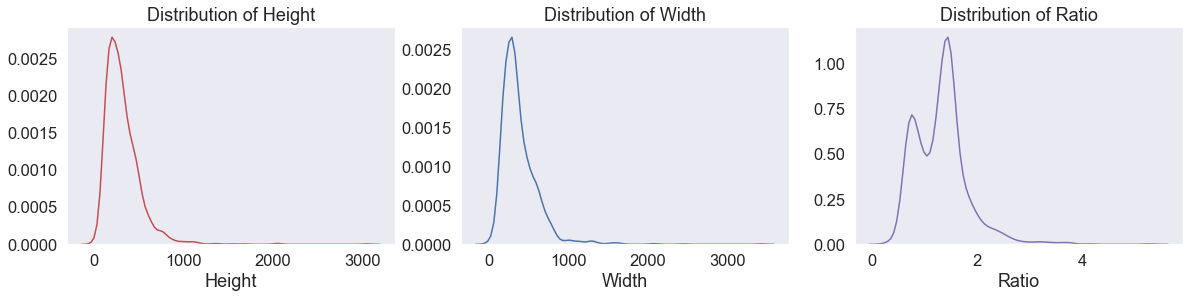

In [122]:
height = training_data["Image"].apply(len)
width = training_data["Image"].apply(lambda x: len(x[0]))
ratio = width/height

# Plotting distributions
plt.figure(figsize=(18,8))

f, axes = plt.subplots(figsize=(20,4), ncols=3, nrows=1)

sns.distplot(height, hist=False, ax=axes[0], color="r")
sns.distplot(width, hist=False, ax=axes[1], color="b")
sns.distplot(ratio, hist=False, ax=axes[2], color="m")

axes[0].set_xlabel("Height")
axes[1].set_xlabel("Width")
axes[2].set_xlabel("Ratio")

axes[0].title.set_text('Distribution of Height')
axes[1].title.set_text('Distribution of Width')
axes[2].title.set_text('Distribution of Ratio')

# Choosing mean heigth and ratio to derive width, to rescale images
mean_ratio = np.mean(ratio)
scale_height = np.mean(height)
scale_width = scale_height * mean_ratio

scaling_size = (int(scale_width), int(scale_height))

print(f"Rescaling to h: {scale_height}, w: {scale_width}");

In [123]:
def get_scaling_size(data):
    """
    Calculating scaling size
    """
    height = data["Image"].apply(len)
    width = data["Image"].apply(lambda x: len(x[0]))
    ratio = width/height
    
    mean_ratio = np.mean(ratio)
    scale_height = np.mean(height)
    scale_width = scale_height * mean_ratio

    return (int(scale_width), int(scale_height))

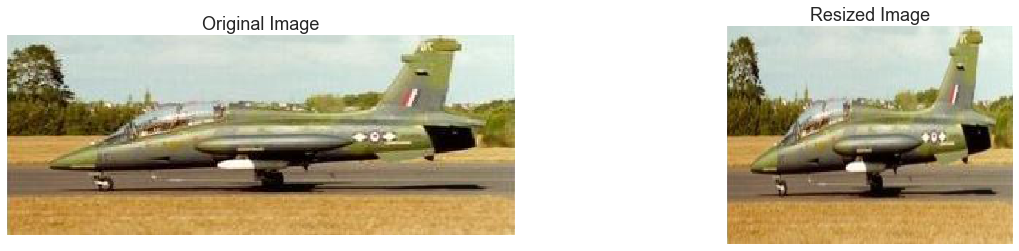

In [124]:
def resize_image(image, size):
    """
    Resizes image to a fixed size
    """
    return cv2.resize(image, size, interpolation = cv2.INTER_AREA)

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)

original_image = training_data.Image[0]
resized_img = resize_image(original_image, scaling_size)

axes[0].imshow(original_image)
axes[1].imshow(resized_img)

axes[0].title.set_text('Original Image')
axes[1].title.set_text('Resized Image')
axes[0].axis('off')
axes[1].axis('off');

##### Scaling images based on width, height and aspect-ratio distribution

In [125]:
training_data["Scaled_Image"] = training_data["Image"].apply(resize_image, args=(scaling_size,))

### Feature extraction

#### Proposed features:

* Image size
* Avg red-channel intensity
* Avg green-channel intensity
* Avg blue-channel intensity
* Aspect-ratio
* Channel stride averages
* Flattened RGB 3D-Histogram
* Average gray-scale intensity
* SIFT - Scale Invariant Feature Transform


In [126]:
def image_size(image):
    """
    Returns the pixel size of the image
    """
    return image.size

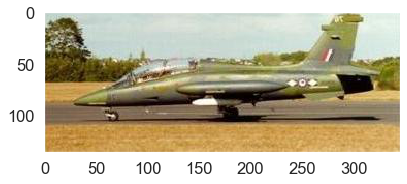

In [127]:
def average_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.mean(channel_intensities)

average_channel_intensity(training_data.Image[0], "R")
show(training_data.Image[0])

In [128]:
def aspectratio(image):
    """
    Returns the aspect ratio of the image (width/height)
    """
    return len(image[0])/len(image)

aspectratio(training_data.Image[0])

2.5441176470588234

##### Exploring the use of color histograms
A color histogram represents the distribution of colors in an image. Our motivation to try this is that different images will have different color distribution. For instance, an image of an airplane on a runway will typically have more dark colors than a leopard on the savannah. So their different color distribution seems like a useful feature to include. Also, it can especially be a helpful feature to distinguish between images where the main object is similar, but the background differs. For instance, an image of a bear in the woods and an image of a teddybear in a bed would seem quite similar when only considering the main object (the bear and the teddybear), but when also considering the background it becomes easier to distinguish the two. 

Here we will explore the use of color histograms, first for gray-scaled images, then for images with RGB-tuples. We will use the cv2.calcHist function from OpenCV to build our histograms.

In [129]:
def get_grayed_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

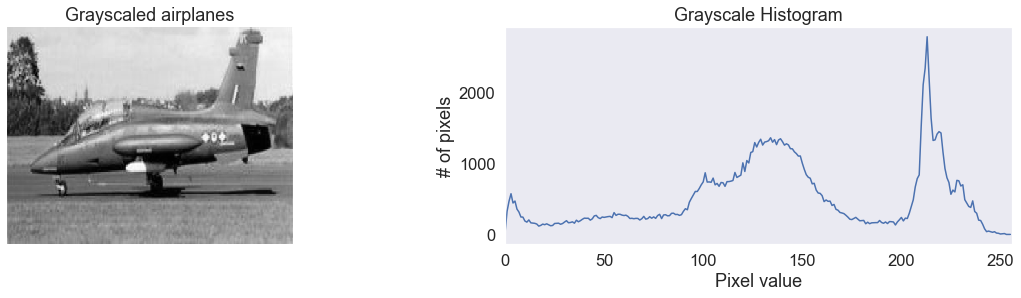

In [130]:
def get_gray_histogram(image):
    """
    cv2.calcHist(images, channels, mask, histSize, ranges)
    # images: list of images we want to compute histogram for
    # channels: list of indexes, specifies the index of the channel we want to compute the histogram for
    For a gray scaled this is [0], for RGB-image this is [0, 1, 2]
    # mask: does not use this
    # histSize: number of bins to use. Must be specified for each channel.
    Here we use 256 bins
    # ranges: possible pixle values, normally between 0 and 256.
    """
    # Convert to grayscale
    grayed_img = get_grayed_image(image)
    return cv2.calcHist([grayed_img], [0], None, [256], [0, 256])

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)

# Showing the grayed image
image_with_label = training_data.loc[53, ['Scaled_Image', 'Label']]
image, label = image_with_label['Scaled_Image'], image_with_label['Label']

axes[0].imshow(get_grayed_image(image), cmap='gray')
axes[0].title.set_text(f'Grayscaled {label_dict[label]}')
axes[0].axis('off')

hist = get_gray_histogram(image)
hist = hist.flatten()

# Plotting the distribution
plt.title('Grayscale Histogram')
plt.xlabel('Pixel value')
plt.ylabel('# of pixels')
plt.xlim(0, 256)
axes[1].plot(hist);


As we can see, the histogram detects a large number of very dark picture (pixel values 0 to ~40), and then many medium dark pixels and very few very light pixels.

Computing a histogram for each color:

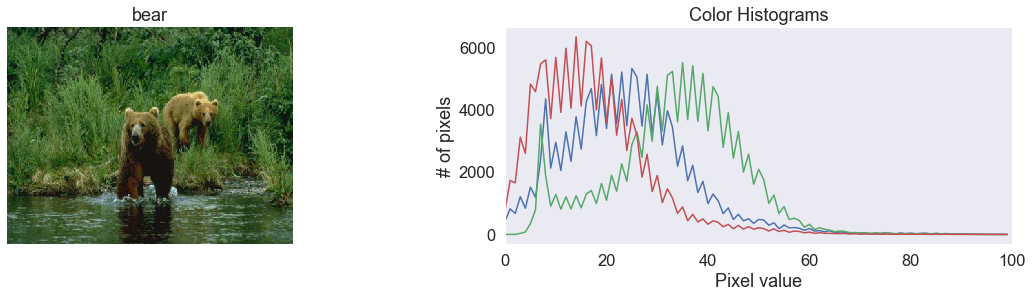

In [131]:
def get_color_histograms(image):
    channels_values = cv2.split(image)
    colors = ("b", "g", "r") # cv2 splits in reverse order 
    hist_list = []
    for (channel, color) in zip(channels_values, colors):
        #Creating a histogram for the current histogram, combining them later
        hist = cv2.calcHist([channel], [0], None, [100], [0, 256])
        hist_list.append(hist)

    return hist_list

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)
img = training_data.loc[80, 'Scaled_Image']

axes[0].imshow(img)
axes[0].axis("off")
axes[0].title.set_text(label_dict[training_data.loc[80, 'Label']])
histograms = get_color_histograms(img)

# Plotting the distribution
plt.title('Color Histograms')
plt.xlabel('Pixel value')
plt.ylabel('# of pixels')
plt.xlim(0, 100)
colors = ['b', 'g', 'r']
for i, hist in enumerate(histograms):  
    axes[1].plot(hist, color=colors[i]);

So far we computed histograms for one color (channel) at the time. To get better features we now compute multi-dimensional histograms. This will give us more informative features that looks at the combination of all three colors. For instance, we now will get a count for how many pixels has a red value of 10, a green value of 30 and a blue value of 60.

Here we use 8 bins for each channel, which results in a feature vector of size 8x8x8 = 512.
This means that one of the bins will count the number of pixels in an image that has red values 0-32, green values 0-32 and blue values 0-32, one bin will count the number of pixels that has red values 0-32, green values 0-32 and blue values 33-64, and so on.  

Computing a 3D histogram:

In [132]:
def get_3D_color_histogram(image, num_bins=8):
    """
    Extracting a 3D color histogram for the RGB (Red, Green, Blue) space using 8 bins for each of these channels
    """
    bins = [num_bins]*3
    #print(image)
    hist = cv2.calcHist([image], [0,1,2], None, bins, [0,256,0,256,0,256])
    #cv2.normalize(hist, hist)
    return hist.flatten()


img = training_data.loc[80, 'Scaled_Image']
histograms = get_color_histograms(img)
mult_dim_histograms = get_3D_color_histogram(img)
print(f"# of features of 3D color histogram for one image: {mult_dim_histograms.shape}")

# of features of 3D color histogram for one image: (512,)


In [133]:
def add_hist_features(df, column):
    """
    Method for computing 3d histograms for column in dataframe, 
    and adding the resulting feature vector as columns in the dataframe
    """
    hist_features = df[column].apply(lambda l: get_3D_color_histogram(l))
    hist_features = np.array([feat for feat in hist_features])
    prefix= 'hist_feat_'
    for i in range(len(hist_features[0])):
        feat_name = prefix+str(i)
        df[feat_name] = hist_features[:,i]

#### Average channel-intensities of image strides

Motivation: Lorem Ipsum

In [134]:
def calculate_stride_channel_averages(image):
    """
    Sliding non-overlapping strides over the image and calculating the average channel intensities for each stride
    Returning the flattened matrix containing the average RGB values for each stride.
    """

    no_width_strides = 8
    height, width = len(image), len(image[0])#scaling_size
    stride_length = width // no_width_strides
    stride_channel_avgs = []
    for i in range(no_width_strides - 1):
        height_start, height_end = stride_length * i, stride_length * (i+1)
        for j in range(no_width_strides - 1):
            width_start, width_end = stride_length * j, stride_length * (j+1)

            pixels = image[height_start : height_end][:, width_start : width_end]
            pixels = pixels.reshape(-1, pixels.shape[-1])
            r = np.mean(pixels[:, 0])
            g = np.mean(pixels[:, 1])
            b = np.mean(pixels[:, 2])

            stride_channel_avgs.append([r, g, b])

    return np.array(stride_channel_avgs).flatten()



#calculate_stride_channel_averages(training_data["Scaled_Image"][1])

In [135]:
def add_stride_features(df, column):
    """
    Method that computes average channel intensities for each stride for one column in dataframe, 
    and adding the resulting feature vector as columns in the dataframe
    """
    stride_features = df[column].apply(lambda l: calculate_stride_channel_averages(l))
    stride_features = np.array([feat for feat in stride_features])
    prefix= 'stride_feat_'
    for i in range(len(stride_features[0])):
        feat_name = prefix+str(i)
        df[feat_name] = stride_features[:,i]
    
add_stride_features(training_data, 'Scaled_Image')
training_data.head(2)

,Image_Id,Image,Label,size,Scaled_Image,stride_feat_0,stride_feat_1,stride_feat_2,stride_feat_3,stride_feat_4,...,stride_feat_137,stride_feat_138,stride_feat_139,stride_feat_140,stride_feat_141,stride_feat_142,stride_feat_143,stride_feat_144,stride_feat_145,stride_feat_146
0,0,"[[[202, 211, 208], [198, 209, 205], [195, 207,...",0,195816,"[[[202, 211, 208], [199, 209, 206], [196, 208,...",155.730873,159.953479,137.096117,201.536332,216.763552,...,95.639216,211.600000,167.547059,94.454902,212.356863,166.615686,92.345098,218.149020,178.200000,108.119608
1,1,"[[[254, 254, 226], [253, 253, 225], [253, 253,...",0,221352,"[[[254, 254, 226], [253, 253, 225], [253, 253,...",253.320646,245.307190,222.247213,247.114571,236.998462,...,190.194118,219.172549,210.162745,179.168627,203.772549,194.776471,164.545098,189.621569,180.617647,150.433333


#### Grayscale Intensity of Image

In [136]:
def grayscale_intensity(image):
    """
    Calculating the average grayscale intensity for all pixels given an image
    """
    grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(grayscaled_image)

print("Airplane:", grayscale_intensity(training_data["Scaled_Image"][1]))
print("Comet:", grayscale_intensity(training_data["Scaled_Image"][33]))

Airplane: 173.08498551166693
Comet: 121.11080524630167


#### SIFT - Scale Invariant Feature Transform

SIFT is a method for images' extracting feature vectors that describe local patches. These features are scale-invariant, as well as invariant to transaltion, rotation and illumination. Therefore we have chosen this to be a good descriptor of our images.

We are using a slightly adjusted version of Sam Lerner's implementation of SIFT (since OpenCV has removed their SIFT-implementation from the default version). The article with the proposed implementation is cited in the Sources-section below.

###### SIFT Keypoints

A SIFT *keypoint* is a circular image region with an orientation. It is described by coordinates x and y, its scale (the radius of the region), and its orientation.

First we will show an example of how SIFT finds keypoints in an image. The code under uses SIFT to extract keypoints and then visualizing these keypoints. Each keypoint is visualized by an circle that varies in size and color. The color and size of the circles represents the size of the region for each keypoint. Small regions has red color, intermediate regions has orange color, and big regions has green color. The size of the circles represents variation of region size within each color. 

In [137]:
from PythonSIFT.sift import SIFT

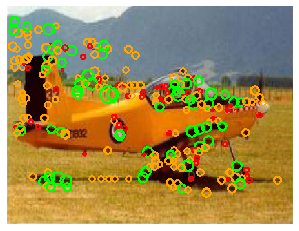

In [138]:
from sklearn.preprocessing import MinMaxScaler

def visualize_keypoints(img):
    sift = SIFT()
    sift.set_image(img)
    kps = sift.get_keypoints() # [[x,y,scale (radius), orientation]...]
    radiuses = []
    for kp in kps:
        radiuses.extend(kp[:,2])
    
    # Normalize radiuses
    min_max_scaler = MinMaxScaler()
    radiuses_norm = min_max_scaler.fit_transform(np.reshape(radiuses, (-1, 1)))[:,0]
    rad_info = pd.Series(radiuses_norm).describe()

    colors = [(255,0,0), (255,165,0), (0,255,0)]
    used_colors = []

    i, limit = 0, 200
    for orientation in kps:
        for kp in orientation:
            s = radiuses_norm[i]
            rgb = colors[0] if s < rad_info["25%"] else colors[1] if s < rad_info["75%"] else colors[2]
            used_colors.append(rgb)
            color = int(radiuses_norm[i]*255)
            cv2.circle(img, (int(kp[0]),int(kp[1])), int(12*s), rgb, 2)
            i += 1
            #if i == limit:
             #   break

    plt.imshow(img)
    plt.axis("off");

img = training_data["Scaled_Image"][2].copy()
visualize_keypoints(img)


It looks like SIFT does a reasonably good job at detecting keypoints in an image.
[INSERT COMPARISON WITH SLIGHTLY ROTATED VERSION OF SAME IMAGE]

##### SIFT Descriptors

Now we have a method for extracting keypoints in images. As said, each keypoints consists of x, y, scale and orientation. One thought is to extract color intensities from each keypoint region in an image, and using these values as features. However, SIFT also provides *descriptors* for each keypoint. These descriptors are even more informative than raw color intensity values, so we will use these descriptors as features instead.

In [139]:
def get_descriptors(img, sift=None):
    sift = sift if sift else SIFT()
    sift.set_image(img)
    try:
        descriptors = np.array(sift.get_features())
    except:
        print("Error when getting descriptors for image.")
        print("Setting descriptors to default.")
        descriptors = []
    # n descriptors for each of the four rotations
    # Each descriptor is an vector of size 128, thus has shape (128, )
    #print(descriptors)

    combined_descriptors = []
    for i in range(len(descriptors)):
        descrs = descriptors[i]
        combined_descriptors.extend(descrs)

    # Check that each descriptor is of the shape (128, )
    # Remove descriptor if not
    #count = 0
    """
    wrongs = []
    for i in range(len(combined_descriptors)):
        desc = combined_descriptors[i]
        if desc.shape != (128, ):
            print("Found descriptor with wrong shape: ", desc.shape)
            wrongs.append(i)
    for index in wrongs:
        del combined_descriptors[index]
    """
    return np.array(combined_descriptors)

img = training_data["Scaled_Image"][2].copy()
descs = get_descriptors(img)
print(len(descs))


325


###### Bag of visual words

Now we have a method for extracting SIFT descriptors for each keypoint in an image. Next is to use the descriptors as features. We will use a "bag of visual words" method to accomplish this.

Intuitively, we look at each descriptor as a visual word. We imagine that one descriptor represents for instance a wheel, while another represents an eye. Each image consists of a collection of such visual words. Then we want to collect every visual words from all images in our training set. This collection will then consist of every possible descriptor from all images. 

However, the descriptors does not have a human-meaningful meaning (such as a wheel or an eye), so we want to group similar descriptors together. 
Therefore we will make clusters of descriptors, such that each group of descriptors captures some broader feature.

Descriptors are 128-dimensional vectors, so we make a dataframe with 128 columns from all of the descriptors in our training set. Next we use KMeans clustering algorithm to find K groups (bins) of descriptors. We can imagine that there will be a group for wheels that contains all descriptors that represent a wheel. 

Then, when evaluating a new image (not from training set) we assign each descriptor to the group they belong to. Then we will count the number of descriptors that was categorized into group 1, the number of descriptors that was categorized into group 2, etc. 
Essentially we are building a histogram for the different descriptors.

This means that SIFT ultimately will contribute with K new features, where the K'th feature represents a count of how many descriptors that belongs to the K'th cluster.

In [140]:
def get_all_descriptors(images, labels, images_ids):    
    """
    Method that collects all descriptors from a series of images and puts them in a dataframe with 128 columns
    Also collecting labels for future plotting 
    """
    images = images.values
    
    descriptor_matrix = []
    desc_labels = []
    desc_images_id = []
    sift = SIFT()
    print(len(images))
    for i, img in enumerate(images):
        descriptors = get_descriptors(img, sift)
        label = labels.iloc[i]
        image_id = images_ids.iloc[i]
        if len(descriptors) != 0:
            desc_labels.extend([label]*len(descriptors))
            descriptor_matrix.append(descriptors)
            desc_images_id.extend([image_id]*len(descriptors))
        print(i)

    return np.concatenate(descriptor_matrix), np.array(desc_labels), np.array(desc_images_id)


In [141]:
subset = training_data.copy()

#matrix, labels, ids = get_all_descriptors(subset['Scaled_Image'], subset['Label'], subset['Image_Id'])
#print(matrix.shape)
#print(labels.shape)
#print(ids.shape)

In [142]:
# Making a dataframe of all descriptors from all images 
# Adding ImageId and label for each descriptor so that we can extract them later,
# without having to compute them again
#descriptor_df = pd.DataFrame(matrix)
#descriptor_df['Image_Id'] = ids
#descriptor_df['Label'] = labels

In [143]:
# Saving all descriptors from all images in training data to file 
# Later, when we split in training and test data, we locate the discriptors images by their image Id
# Only descriptors from training images will be used in the training
#descriptor_df.to_csv('descriptors.csv', index=False)

In [144]:
# Trying k-nearest neighbours
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [145]:
y = subset.copy()['Label']
x = subset.copy().drop(columns=['Label'])

In [146]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(1200, 151)
(301, 151)


In [147]:
# Getting descriptors that corresponds to images in train_x and test_x
descriptor_df = pd.read_csv('descriptors.csv')
train_descriptors = descriptor_df.loc[descriptor_df['Image_Id'].isin(x_train['Image_Id'])]
test_descriptors = descriptor_df.loc[descriptor_df['Image_Id'].isin(x_test['Image_Id'])]
display(test_descriptors['Label'].value_counts())
display(train_descriptors['Label'].value_counts())

9     12054
12    11851
4      8612
19     8469
0      8372
14     8105
15     7883
13     7131
8      5205
10     4805
1      3984
2      3966
18     3919
5      3904
7      3805
11     3599
17     3081
6      2434
16     2211
3      1211
Name: Label, dtype: int64

9     44849
12    34853
4     27838
1     26276
14    25322
7     24879
13    23248
15    22915
8     22084
0     21203
19    21186
17    19392
16    18679
5     17851
10    16040
18    15515
11    11805
2     11590
6      8226
3      5727
Name: Label, dtype: int64

In [148]:
train_descriptors_y = train_descriptors['Label']
train_descriptors_x = train_descriptors.drop(columns=['Label', 'Image_Id'])
test_descriptors_y = test_descriptors['Label']
test_descriptors_x = test_descriptors.drop(columns=['Label', 'Image_Id'])

In [149]:
train_descriptors.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,Image_Id,Label
332,0.000000,0.000000e+00,0.000000,2.561652e-03,0.060592,0.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.129529,7.589159e-08,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.045006,1,0
333,0.009853,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.009725,0.000000,0.000000e+00,...,0.228997,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.021879,1,0
334,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.217066,0.0,0.000000,0.000000,1.062282e-14,...,0.000000,0.000000e+00,0.000000,0.00000,8.781657e-08,0.274305,1.606967e-14,0.000000,1,0
335,0.000000,0.000000e+00,0.040060,5.259739e-08,0.000000,0.000000,0.0,0.000000,0.001179,2.180327e-02,...,0.000000,0.000000e+00,0.030422,0.15483,0.000000e+00,0.000000,0.000000e+00,0.000000,1,0
336,0.000000,4.968198e-08,0.395367,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,5.977671e-14,...,0.000000,0.000000e+00,0.000000,0.00000,3.953665e-01,0.000000,0.000000e+00,0.000000,1,0


In [150]:
descriptor_df.drop(columns=['Label'], inplace=True)
#train_descriptors.drop(columns=['Label'], inplace=True)

In [151]:
descriptor_dict = {}
for i, descr in descriptor_df.iterrows():
    imageid = descr['Image_Id']
    descriptors = list(descr)[:-1]
    if imageid in descriptor_dict:
        descriptor_dict[imageid].append(descriptors)
    else:
        descriptor_dict[imageid] = [descriptors]


In [105]:
print(len(descriptor_dict[0]))
len(descriptor_df.loc[descriptor_df['Image_Id'] == 0])

332


332

In [152]:
import time 
start = time.time()
knn = KNeighborsClassifier(p=1)
knn.fit(train_descriptors_x, train_descriptors_y)
end = time.time()
elapsed = end - start
print(f"Fitting time: {elapsed}s")

Fitting time: 230.25940704345703s


In [153]:
import collections
def predict_class_by_descriptors(model, descriptors):
    """
    Method that takes in a model an image's descriptors, and predicts a class
    """
    neighbours = []
    for descriptor in descriptors:
        nearest = model.predict([descriptor])[0]
        neighbours.append(nearest)
    counts = collections.Counter(neighbours)
    pred = counts.most_common(1)[0][0]
    return pred

In [106]:
from random import randrange
# Evaluating
print(len(x_test))
preds = []
for i, row in x_test.iterrows():
    try:
        imageid = row['Image_Id']
        descriptors = descriptor_dict[imageid]
        #descriptors = test_descriptors.loc[test_descriptors['Image_Id'] == imageid].drop(columns=['Label', 'Image_Id'])
        pred = predict_class_by_descriptors(knn, descriptors)
    except:
        print("Something wrong happend. Predicting randomly.")
        pred = randrange(21)
    preds.append(pred)
    print(i)
    


301
Something wrong happend. Predicting randomly.
251
Something wrong happend. Predicting randomly.
23
Something wrong happend. Predicting randomly.
15
Something wrong happend. Predicting randomly.
364
Something wrong happend. Predicting randomly.
1334
Something wrong happend. Predicting randomly.
1493
Something wrong happend. Predicting randomly.
1123
Something wrong happend. Predicting randomly.
977
Something wrong happend. Predicting randomly.
1328
Something wrong happend. Predicting randomly.
805
Something wrong happend. Predicting randomly.
1027
Something wrong happend. Predicting randomly.
1179
Something wrong happend. Predicting randomly.
45
Something wrong happend. Predicting randomly.
1126
Something wrong happend. Predicting randomly.
209
Something wrong happend. Predicting randomly.
983
Something wrong happend. Predicting randomly.
4
Something wrong happend. Predicting randomly.
240
Something wrong happend. Predicting randomly.
812
Something wrong happend. Predicting randomly

In [71]:
print(len(preds))
y_train_2 = y_train

accuracy = accuracy_score(preds, y_test)
print(accuracy)


301
0.17275747508305647


In [72]:
print(preds)

[8, 9, 14, 9, 9, 9, 9, 4, 9, 12, 0, 9, 9, 9, 9, 12, 0, 9, 14, 9, 14, 18, 6, 9, 14, 9, 6, 9, 9, 9, 14, 0, 9, 9, 9, 5, 9, 9, 0, 9, 9, 9, 9, 12, 14, 9, 9, 9, 9, 14, 9, 9, 0, 6, 0, 9, 0, 14, 9, 18, 5, 0, 16, 9, 9, 9, 9, 9, 4, 9, 11, 14, 9, 9, 12, 0, 9, 0, 19, 14, 9, 9, 14, 0, 3, 3, 9, 13, 9, 9, 0, 9, 16, 14, 9, 9, 9, 9, 9, 9, 14, 7, 1, 9, 19, 9, 14, 0, 0, 9, 0, 4, 0, 9, 19, 9, 8, 9, 0, 9, 15, 9, 16, 12, 17, 9, 9, 9, 11, 0, 9, 9, 9, 9, 9, 19, 9, 14, 9, 9, 9, 9, 9, 3, 9, 0, 4, 9, 9, 0, 14, 0, 4, 9, 9, 12, 9, 9, 14, 9, 9, 3, 9, 0, 11, 0, 4, 9, 9, 9, 19, 2, 9, 6, 9, 9, 14, 9, 9, 9, 0, 4, 12, 9, 0, 9, 9, 9, 14, 9, 14, 17, 14, 12, 9, 14, 0, 14, 9, 0, 9, 16, 9, 9, 0, 0, 9, 9, 3, 9, 0, 15, 9, 9, 9, 12, 14, 9, 8, 9, 0, 9, 0, 5, 14, 9, 9, 3, 9, 0, 9, 9, 12, 12, 9, 9, 9, 14, 14, 14, 17, 9, 9, 14, 3, 14, 9, 9, 9, 13, 2, 9, 9, 14, 9, 0, 0, 9, 9, 9, 12, 9, 2, 7, 16, 0, 9, 14, 9, 12, 9, 9, 9, 0, 12, 9, 9, 9, 0, 9, 14, 8, 16, 9, 14, 12, 5, 12, 9, 9, 9, 14, 9, 9, 9, 9, 14, 17, 9, 14, 5]


In [74]:
# Finding the nearest neighbour for every descriptor in an image
# Dictionary keeps count of the predicted classes of each descriptor
n = 900
test_image = training_data.loc[n]['Scaled_Image']
test_label = training_data.loc[n]['Label']
#test_image = training_data.loc[training_data['Image_Id'] == 2]['Scaled_Image'].values[0]
#test_label = training_data.loc[training_data['Image_Id'] == 2]['Label'].values

import collections
classes = [0, 'Airplanes', 'Bear', 'Blimp', 'Comet', 'Crab', 'Dog', 'Dolphin', 'Giraffe','Goat', 'Gorilla', 'Kangaroo',
 'Killer-Whale', 'Leopards', 'Llama', 'Penguin', 'Porcupine', 'Teddy-Bear', 'Triceratops', 'Unicorn', 'Zebra']

descriptors = get_descriptors(test_image)
imageid = training_data.loc[n]['Image_Id']
descriptors2 = test_descriptors.loc[test_descriptors['Image_Id'] == imageid].drop(columns=['Label', 'Image_Id']).values
print(descriptors)
print("-"*50)
print(descriptors2)

"""

neighbours = []

for descriptor in descriptors:
    nearest = knn.predict([descriptor])[0]
    neighbours.append(nearest)

counts = collections.Counter(neighbours)
print(counts)
pred = counts.most_common(1)[0][0]
"""
pred = predict_class_by_descriptors(knn, descriptors)
pred2 = predict_class_by_descriptors(knn, descriptors2)
print(pred2)
print(f"predicted: {classes[pred]}")
print(f"actual: {classes[test_label]}")
show(test_image)


#preds = model.predict([x_test.iloc[0]])
#acc = accuracy_score(preds, [y_test.iloc[0]])
#print(f"Accuracy on test set: {acc}")

[[1.7142983e-13 7.3846593e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 2.1012771e-01]
 [1.1782023e-01 0.0000000e+00 0.0000000e+00 ... 7.6946002e-08
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0604683e-08 6.9371609e-08]
 ...
 [8.9040640e-08 3.2879261e-14 9.3147658e-02 ... 4.2651369e-08
  0.0000000e+00 0.0000000e+00]
 [1.8959669e-02 1.3143983e-01 3.4975365e-08 ... 0.0000000e+00
  0.0000000e+00 3.7398271e-15]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.9300057e-14]]
--------------------------------------------------
[]


IndexError: list index out of range

In [112]:
x = descriptor_df.drop(columns=['Label'])

,Image_Id,Image,Label,size,Scaled_Image,stride_feat_0,stride_feat_1,stride_feat_2,stride_feat_3,stride_feat_4,...,stride_feat_137,stride_feat_138,stride_feat_139,stride_feat_140,stride_feat_141,stride_feat_142,stride_feat_143,stride_feat_144,stride_feat_145,stride_feat_146
0,0,"[[[202, 211, 208], [198, 209, 205], [195, 207,...",1,195816,"[[[202, 211, 208], [199, 209, 206], [196, 208,...",155.730873,159.953479,137.096117,201.536332,216.763552,...,95.639216,211.600000,167.547059,94.454902,212.356863,166.615686,92.345098,218.149020,178.200000,108.119608
1,1,"[[[254, 254, 226], [253, 253, 225], [253, 253,...",1,221352,"[[[254, 254, 226], [253, 253, 225], [253, 253,...",253.320646,245.307190,222.247213,247.114571,236.998462,...,190.194118,219.172549,210.162745,179.168627,203.772549,194.776471,164.545098,189.621569,180.617647,150.433333
2,2,"[[[243, 244, 239], [238, 240, 235], [244, 246,...",1,194535,"[[[243, 244, 239], [240, 241, 236], [240, 242,...",145.788158,172.697809,184.627835,147.207228,170.068435,...,80.050980,204.660784,162.903922,81.392157,202.574510,158.474510,77.758824,193.507843,151.956863,70.423529
3,3,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",1,200430,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",157.725106,144.439062,128.629373,149.104575,125.599000,...,25.531373,147.460784,128.927451,28.574510,150.225490,133.409804,32.000000,152.327451,140.686275,37.970588
4,4,"[[[254, 255, 249], [254, 255, 249], [253, 254,...",1,208560,"[[[254, 255, 249], [254, 255, 249], [253, 254,...",104.783929,120.664360,94.387543,90.644368,102.855440,...,8.425490,154.200000,156.578431,6.803922,160.533333,161.650980,5.509804,159.860784,162.556863,9.960784


In [117]:
test_descriptors_x.shape

(25284, 128)

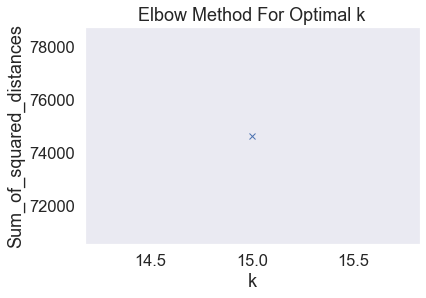

In [122]:
sum_of_squared_distances = []
K = range(15,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train_descriptors_x)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [163]:
def get_cluster_distribution(preds, k):
    preds = np.append(preds, [i for i in range(k)])
    unique, counts = np.unique(preds, return_counts=True)
    counts = dict(zip(unique, counts))
    # Get proportion of descriptors in each bin
    props = np.array(list(counts.values()))/len(preds)
    return props

In [125]:
k = 20
km = KMeans(n_clusters=k)
km.fit(train_descriptors_x)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 77572.76896848476
start iteration
done sorting
end inner loop
Iteration 1, inertia 74713.99245352775
start iteration
done sorting
end inner loop
Iteration 2, inertia 74057.05807126031
start iteration
done sorting
end inner loop
Iteration 3, inertia 73764.11424351938
start iteration
done sorting
end inner loop
Iteration 4, inertia 73621.42388045476
start iteration
done sorting
end inner loop
Iteration 5, inertia 73533.96857014982
start iteration
done sorting
end inner loop
Iteration 6, inertia 73464.4919142677
start iteration
done sorting
end inner loop
Iteration 7, inertia 73402.96990555781
start iteration
done sorting
end inner loop
Iteration 8, inertia 73349.96742959289
start iteration
done sorting
end inner loop
Iteration 9, inertia 73310.04349202994
start iteration
done sorting
end inner loop
Iteration 10, inertia 73284.8289833357
start iteration
done sorting
end inner loop
Iteration 11, inerti

Iteration 99, inertia 73096.92566432484
start iteration
done sorting
end inner loop
Iteration 100, inertia 73096.91689974877
start iteration
done sorting
end inner loop
Iteration 101, inertia 73096.9078434412
start iteration
done sorting
end inner loop
Iteration 102, inertia 73096.89996781008
start iteration
done sorting
end inner loop
Iteration 103, inertia 73096.8904811596
start iteration
done sorting
end inner loop
Iteration 104, inertia 73096.88144430949
start iteration
done sorting
end inner loop
Iteration 105, inertia 73096.8727994254
start iteration
done sorting
end inner loop
Iteration 106, inertia 73096.8682696896
start iteration
done sorting
end inner loop
Iteration 107, inertia 73096.86349553277
start iteration
done sorting
end inner loop
Iteration 108, inertia 73096.8530717669
start iteration
done sorting
end inner loop
Iteration 109, inertia 73096.83499731676
start iteration
done sorting
end inner loop
Iteration 110, inertia 73096.82247431917
start iteration
done sorting
e

Iteration 66, inertia 73174.0449560587
start iteration
done sorting
end inner loop
Iteration 67, inertia 73173.96533121572
start iteration
done sorting
end inner loop
Iteration 68, inertia 73173.90475322526
start iteration
done sorting
end inner loop
Iteration 69, inertia 73173.84498818252
start iteration
done sorting
end inner loop
Iteration 70, inertia 73173.7820273271
start iteration
done sorting
end inner loop
Iteration 71, inertia 73173.70523036322
start iteration
done sorting
end inner loop
Iteration 72, inertia 73173.60355214524
start iteration
done sorting
end inner loop
Iteration 73, inertia 73173.48832857228
start iteration
done sorting
end inner loop
Iteration 74, inertia 73173.38443018889
start iteration
done sorting
end inner loop
Iteration 75, inertia 73173.25829563351
start iteration
done sorting
end inner loop
Iteration 76, inertia 73173.16683409718
start iteration
done sorting
end inner loop
Iteration 77, inertia 73173.06200817466
start iteration
done sorting
end inner

end inner loop
Iteration 20, inertia 73196.84798025752
start iteration
done sorting
end inner loop
Iteration 21, inertia 73183.10393838314
start iteration
done sorting
end inner loop
Iteration 22, inertia 73171.67606294095
start iteration
done sorting
end inner loop
Iteration 23, inertia 73162.19534381975
start iteration
done sorting
end inner loop
Iteration 24, inertia 73155.1874187639
start iteration
done sorting
end inner loop
Iteration 25, inertia 73149.92412790107
start iteration
done sorting
end inner loop
Iteration 26, inertia 73145.82549449141
start iteration
done sorting
end inner loop
Iteration 27, inertia 73142.65727551209
start iteration
done sorting
end inner loop
Iteration 28, inertia 73140.06504179577
start iteration
done sorting
end inner loop
Iteration 29, inertia 73138.05102248398
start iteration
done sorting
end inner loop
Iteration 30, inertia 73136.45410617105
start iteration
done sorting
end inner loop
Iteration 31, inertia 73135.15836464835
start iteration
done s

Iteration 118, inertia 73107.48652515012
start iteration
done sorting
end inner loop
Iteration 119, inertia 73107.44589611121
start iteration
done sorting
end inner loop
Iteration 120, inertia 73107.4146234004
start iteration
done sorting
end inner loop
Iteration 121, inertia 73107.38672833015
start iteration
done sorting
end inner loop
Iteration 122, inertia 73107.35933575065
start iteration
done sorting
end inner loop
Iteration 123, inertia 73107.32627656526
start iteration
done sorting
end inner loop
Iteration 124, inertia 73107.28349202624
start iteration
done sorting
end inner loop
Iteration 125, inertia 73107.23061441185
start iteration
done sorting
end inner loop
Iteration 126, inertia 73107.19092568403
start iteration
done sorting
end inner loop
Iteration 127, inertia 73107.15872478041
start iteration
done sorting
end inner loop
Iteration 128, inertia 73107.11721912587
start iteration
done sorting
end inner loop
Iteration 129, inertia 73107.07601672981
start iteration
done sort

Iteration 64, inertia 73204.503083984
start iteration
done sorting
end inner loop
Iteration 65, inertia 73202.03968151672
start iteration
done sorting
end inner loop
Iteration 66, inertia 73198.7037101651
start iteration
done sorting
end inner loop
Iteration 67, inertia 73194.40764734827
start iteration
done sorting
end inner loop
Iteration 68, inertia 73189.39665467244
start iteration
done sorting
end inner loop
Iteration 69, inertia 73184.20286055397
start iteration
done sorting
end inner loop
Iteration 70, inertia 73178.983304665
start iteration
done sorting
end inner loop
Iteration 71, inertia 73173.91084284757
start iteration
done sorting
end inner loop
Iteration 72, inertia 73169.36466929871
start iteration
done sorting
end inner loop
Iteration 73, inertia 73165.9036972329
start iteration
done sorting
end inner loop
Iteration 74, inertia 73163.39899668908
start iteration
done sorting
end inner loop
Iteration 75, inertia 73161.59420382006
start iteration
done sorting
end inner loo

Iteration 162, inertia 73135.52834955805
start iteration
done sorting
end inner loop
Iteration 163, inertia 73135.52133015341
start iteration
done sorting
end inner loop
Iteration 164, inertia 73135.51504948622
start iteration
done sorting
end inner loop
Iteration 165, inertia 73135.50858344842
start iteration
done sorting
end inner loop
Iteration 166, inertia 73135.49954839343
start iteration
done sorting
end inner loop
Iteration 167, inertia 73135.48249452068
start iteration
done sorting
end inner loop
Iteration 168, inertia 73135.47192294431
start iteration
done sorting
end inner loop
Iteration 169, inertia 73135.45757607643
start iteration
done sorting
end inner loop
Iteration 170, inertia 73135.44511139054
start iteration
done sorting
end inner loop
Iteration 171, inertia 73135.43671206794
start iteration
done sorting
end inner loop
Iteration 172, inertia 73135.42845467292
start iteration
done sorting
end inner loop
Iteration 173, inertia 73135.42102264758
start iteration
done sor

Iteration 78, inertia 73128.00061190056
start iteration
done sorting
end inner loop
Iteration 79, inertia 73127.92374336085
start iteration
done sorting
end inner loop
Iteration 80, inertia 73127.85837993791
start iteration
done sorting
end inner loop
Iteration 81, inertia 73127.80603537834
start iteration
done sorting
end inner loop
Iteration 82, inertia 73127.73433326572
start iteration
done sorting
end inner loop
Iteration 83, inertia 73127.66608652641
start iteration
done sorting
end inner loop
Iteration 84, inertia 73127.58840230672
start iteration
done sorting
end inner loop
Iteration 85, inertia 73127.53791089948
start iteration
done sorting
end inner loop
Iteration 86, inertia 73127.48617358356
start iteration
done sorting
end inner loop
Iteration 87, inertia 73127.45259616774
start iteration
done sorting
end inner loop
Iteration 88, inertia 73127.41622264146
start iteration
done sorting
end inner loop
Iteration 89, inertia 73127.37515767346
start iteration
done sorting
end inn

Iteration 6, inertia 73608.45736178028
start iteration
done sorting
end inner loop
Iteration 7, inertia 73551.00343030014
start iteration
done sorting
end inner loop
Iteration 8, inertia 73510.67741447469
start iteration
done sorting
end inner loop
Iteration 9, inertia 73479.82592143115
start iteration
done sorting
end inner loop
Iteration 10, inertia 73455.81682504414
start iteration
done sorting
end inner loop
Iteration 11, inertia 73437.24271472024
start iteration
done sorting
end inner loop
Iteration 12, inertia 73420.86950623401
start iteration
done sorting
end inner loop
Iteration 13, inertia 73403.5926909569
start iteration
done sorting
end inner loop
Iteration 14, inertia 73385.19807492188
start iteration
done sorting
end inner loop
Iteration 15, inertia 73365.76670977926
start iteration
done sorting
end inner loop
Iteration 16, inertia 73345.2225662319
start iteration
done sorting
end inner loop
Iteration 17, inertia 73323.82342187632
start iteration
done sorting
end inner loo

Iteration 25, inertia 73173.06489011561
start iteration
done sorting
end inner loop
Iteration 26, inertia 73168.58670663975
start iteration
done sorting
end inner loop
Iteration 27, inertia 73164.68670535338
start iteration
done sorting
end inner loop
Iteration 28, inertia 73160.96343378432
start iteration
done sorting
end inner loop
Iteration 29, inertia 73157.68884175326
start iteration
done sorting
end inner loop
Iteration 30, inertia 73154.26999636463
start iteration
done sorting
end inner loop
Iteration 31, inertia 73150.52686693934
start iteration
done sorting
end inner loop
Iteration 32, inertia 73146.88797472812
start iteration
done sorting
end inner loop
Iteration 33, inertia 73143.32315178543
start iteration
done sorting
end inner loop
Iteration 34, inertia 73139.54488377836
start iteration
done sorting
end inner loop
Iteration 35, inertia 73136.07729829114
start iteration
done sorting
end inner loop
Iteration 36, inertia 73133.01379057344
start iteration
done sorting
end inn

Iteration 123, inertia 73064.14247740216
start iteration
done sorting
end inner loop
Iteration 124, inertia 73063.92437860486
start iteration
done sorting
end inner loop
Iteration 125, inertia 73063.73612773312
start iteration
done sorting
end inner loop
Iteration 126, inertia 73063.58804265388
start iteration
done sorting
end inner loop
Iteration 127, inertia 73063.48128301425
start iteration
done sorting
end inner loop
Iteration 128, inertia 73063.39442332124
start iteration
done sorting
end inner loop
Iteration 129, inertia 73063.31994174776
start iteration
done sorting
end inner loop
Iteration 130, inertia 73063.25054697323
start iteration
done sorting
end inner loop
Iteration 131, inertia 73063.17937053686
start iteration
done sorting
end inner loop
Iteration 132, inertia 73063.09156361785
start iteration
done sorting
end inner loop
Iteration 133, inertia 73062.97320190325
start iteration
done sorting
end inner loop
Iteration 134, inertia 73062.89537452089
start iteration
done sor

Iteration 39, inertia 73131.71560972207
start iteration
done sorting
end inner loop
Iteration 40, inertia 73129.18456801417
start iteration
done sorting
end inner loop
Iteration 41, inertia 73126.81059724271
start iteration
done sorting
end inner loop
Iteration 42, inertia 73124.43827263247
start iteration
done sorting
end inner loop
Iteration 43, inertia 73121.79553764185
start iteration
done sorting
end inner loop
Iteration 44, inertia 73118.5323477075
start iteration
done sorting
end inner loop
Iteration 45, inertia 73114.73189422046
start iteration
done sorting
end inner loop
Iteration 46, inertia 73110.93216396622
start iteration
done sorting
end inner loop
Iteration 47, inertia 73107.31289417071
start iteration
done sorting
end inner loop
Iteration 48, inertia 73103.8340311873
start iteration
done sorting
end inner loop
Iteration 49, inertia 73100.5830673744
start iteration
done sorting
end inner loop
Iteration 50, inertia 73097.62080054107
start iteration
done sorting
end inner 

Iteration 137, inertia 73074.64199786444
start iteration
done sorting
end inner loop
Iteration 138, inertia 73074.63806139491
start iteration
done sorting
end inner loop
Iteration 139, inertia 73074.63233459672
start iteration
done sorting
end inner loop
Iteration 140, inertia 73074.62781936483
start iteration
done sorting
end inner loop
Iteration 141, inertia 73074.62414391428
start iteration
done sorting
end inner loop
Iteration 142, inertia 73074.61707423333
start iteration
done sorting
end inner loop
Iteration 143, inertia 73074.61235028674
start iteration
done sorting
end inner loop
Iteration 144, inertia 73074.6093088208
start iteration
done sorting
end inner loop
Iteration 145, inertia 73074.60698081205
start iteration
done sorting
end inner loop
Iteration 146, inertia 73074.60662895301
center shift 3.887386e-04 within tolerance 6.436500e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 77797.61903989581
start iteration
done sorting
end

end inner loop
Iteration 1, inertia 75220.69559811878
start iteration
done sorting
end inner loop
Iteration 2, inertia 74402.83579582888
start iteration
done sorting
end inner loop
Iteration 3, inertia 74100.97149622341
start iteration
done sorting
end inner loop
Iteration 4, inertia 73921.9074703782
start iteration
done sorting
end inner loop
Iteration 5, inertia 73796.57778019489
start iteration
done sorting
end inner loop
Iteration 6, inertia 73669.12720683962
start iteration
done sorting
end inner loop
Iteration 7, inertia 73581.39322901935
start iteration
done sorting
end inner loop
Iteration 8, inertia 73510.78775689936
start iteration
done sorting
end inner loop
Iteration 9, inertia 73454.48040498323
start iteration
done sorting
end inner loop
Iteration 10, inertia 73410.87071061457
start iteration
done sorting
end inner loop
Iteration 11, inertia 73377.14195479924
start iteration
done sorting
end inner loop
Iteration 12, inertia 73351.36177998122
start iteration
done sorting
en

Iteration 100, inertia 73184.81045316608
start iteration
done sorting
end inner loop
Iteration 101, inertia 73182.94447672484
start iteration
done sorting
end inner loop
Iteration 102, inertia 73181.09858435678
start iteration
done sorting
end inner loop
Iteration 103, inertia 73179.3146362174
start iteration
done sorting
end inner loop
Iteration 104, inertia 73178.10638551373
start iteration
done sorting
end inner loop
Iteration 105, inertia 73177.2236744996
start iteration
done sorting
end inner loop
Iteration 106, inertia 73176.41908327666
start iteration
done sorting
end inner loop
Iteration 107, inertia 73175.66700998238
start iteration
done sorting
end inner loop
Iteration 108, inertia 73174.85109344395
start iteration
done sorting
end inner loop
Iteration 109, inertia 73173.86183664514
start iteration
done sorting
end inner loop
Iteration 110, inertia 73173.045855215
start iteration
done sorting
end inner loop
Iteration 111, inertia 73172.43431877565
start iteration
done sorting

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

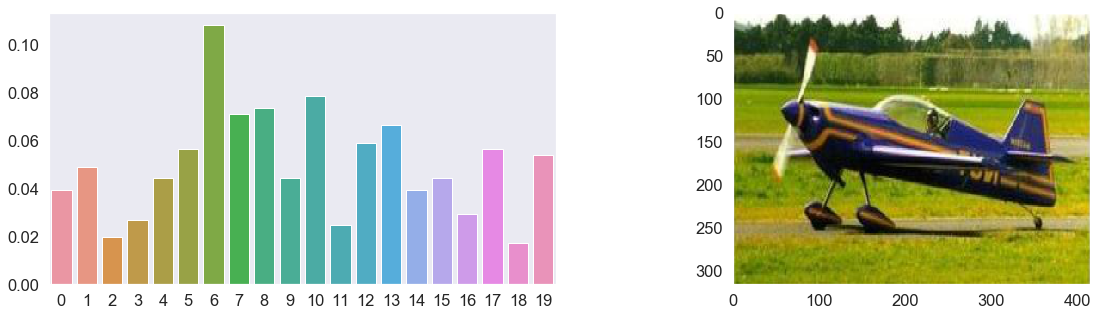

In [164]:
test_image = training_data.iloc[4]['Scaled_Image']
test_label = labels[4]

descriptors = get_descriptors(test_image)
preds = km.predict(descriptors)
# Get proportion of descriptors in each bin
props = get_cluster_distribution(preds, k)

f, axes = plt.subplots(figsize=(20, 5), ncols=2, nrows=1)
sns.barplot([i for i in range(k)], props, ax=axes[0])
axes[1].imshow(test_image);
limits = axes[0].get_ylim();

In [143]:
def get_descriptors_from_file(img_id, descriptor_df):
    descriptors = descriptor_df.loc[descriptor_df['Image_Id'] == img_id].drop(columns=['Label', 'Image_Id'])
    return descriptors

In [165]:
descriptor_df = pd.read_csv('descriptors.csv')
cluster_dists = []
j = 0
for i, row in training_data.loc[training_data['Label']==2].iterrows():
    try:
        img_id = row['Image_Id']
        descriptors = get_descriptors_from_file(img_id, descriptor_df)
        preds = km.predict(descriptors)
    except ValueError:
        preds = [i for i in range(k)]
    cluster_dist = get_cluster_distribution(preds, k)
    cluster_dists.append(cluster_dist)

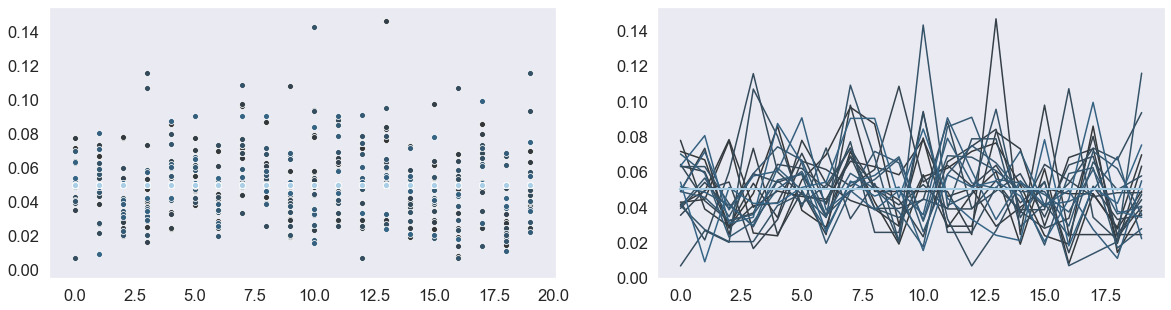

In [166]:
palette = sns.color_palette("Blues_d", len(cluster_dists))
f, axes = plt.subplots(figsize=(20, 5), ncols=2, nrows=1)
for i, arr in enumerate(cluster_dists):
    sns.scatterplot([i for i in range(k)], arr, color=palette[i], ax=axes[0])
    sns.lineplot([i for i in range(k)], arr, color=palette[i], ax=axes[1])

For each image we do the following:

1) Find its descriptors

2) Assign each descriptor to a bin (cluster) 

3) Find the proportion of descriptors that went into each cluster

4) Add these k proportions as features 


In [191]:
def get_cluster_features_for_image(img_id, descriptor_df):
    descriptors = get_descriptors_from_file(img_id, descriptor_df)
    try: 
        preds = km.predict(descriptors)
    except:
        preds = [i for i in range(k)]
    cluster_dist = get_cluster_distribution(preds, k)
    return cluster_dist

In [246]:
def get_cluster_features_for_all_images(df, descriptor_df):
    cluster_features = []
    cluster_distribution = df['Image_Id'].apply(lambda i: get_cluster_features_for_image(i, descriptor_df)) 
    for row in cluster_distribution:
        cluster_features.append(row)
    return np.array(cluster_features)

In [249]:
def add_cluster_features_to_df(df, descriptor_df, k):
    cluster_features = get_cluster_features_for_all_images(df, descriptor_df)
    for i in range(k):
        column = f"descriptor_cluster_{i}"
        df[column] = cluster_features[:, i]    

#### Performing k-fold cross validation to find optimal nr of k

In [294]:
data = feature_frame()
#add_cluster_features_to_df(data, descriptor_df, k)
data.head(1)

Fetching label '.DS_Store'
Fetching label 'airplanes'
Fetching label 'bear'
Fetching label 'blimp'
	Gray image ('blimp_0022.jpg') was loaded, converting to RGB
Fetching label 'comet'
	Gray image ('comet_0006.jpg') was loaded, converting to RGB
	Gray image ('comet_0011.jpg') was loaded, converting to RGB
	Gray image ('comet_0013.jpg') was loaded, converting to RGB
	Gray image ('comet_0021.jpg') was loaded, converting to RGB
	Gray image ('comet_0036.jpg') was loaded, converting to RGB
	Gray image ('comet_0038.jpg') was loaded, converting to RGB
	Gray image ('comet_0041.jpg') was loaded, converting to RGB
	Gray image ('comet_0049.jpg') was loaded, converting to RGB
	Gray image ('comet_0052.jpg') was loaded, converting to RGB
	Gray image ('comet_0053.jpg') was loaded, converting to RGB
	Gray image ('comet_0057.jpg') was loaded, converting to RGB
	Gray image ('comet_0058.jpg') was loaded, converting to RGB
Fetching label 'crab'
	Gray image ('crab_0045.jpg') was loaded, converting to RGB
Fet

,Image_Id,Label,Size,AspectRatio,Red_intensity,Green_intensity,Blue_intensity,Grayscale_intensity,hist_feat_0,hist_feat_1,...,stride_feat_137,stride_feat_138,stride_feat_139,stride_feat_140,stride_feat_141,stride_feat_142,stride_feat_143,stride_feat_144,stride_feat_145,stride_feat_146
0,0,1,141168,2.544118,165.015148,152.765121,116.224673,143.250061,5153.0,1.0,...,92.185185,209.740741,165.542824,91.915509,211.186343,165.200231,90.634259,216.908565,176.052083,105.138889


In [295]:
y = data['Label']
x = data.drop(columns=['Label', 'Image_Id'])
print("Done preprocessing")

Done preprocessing


 We expect all external sources sited, and significant indication of EDA. 

In [296]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [297]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [298]:
model = LogisticRegression()
model.fit(x_train_scaled, y_train)
preds = model.predict(x_test_scaled)
acc = accuracy_score(preds, y_test)
print(acc)

0.3588039867109635


In [299]:
model = KNeighborsClassifier(10)
model.fit(x_train, y_train)
preds = model.predict(x_test)
acc = accuracy_score(preds, y_test)
print(acc)

0.24916943521594684


In [300]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
preds = model.predict(x_test)
acc = accuracy_score(preds, y_test)
print(acc)

0.29900332225913623


In [301]:
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train, y_train)
preds = model.predict(x_test)
acc = accuracy_score(preds, y_test)
print(acc)

s = model.feature_importances_
index_importance_sorted = sorted(range(len(s)), key=lambda k: s[k], reverse=True)
top_index = index_importance_sorted[:15]

print("\nMost importance features:")
for index in top_index:
    print(f"Feature name: {x_train.columns[index]}, Importance={s[index]}")

0.4119601328903654

Most importance features:
Feature name: Size, Importance=0.016106099429819668
Feature name: AspectRatio, Importance=0.013807077535550842
Feature name: hist_feat_145, Importance=0.00777090129120652
Feature name: hist_feat_218, Importance=0.006982048705016826
Feature name: hist_feat_438, Importance=0.0060961417495806955
Feature name: hist_feat_217, Importance=0.005825391696077834
Feature name: hist_feat_65, Importance=0.005731761048106357
Feature name: hist_feat_144, Importance=0.00540671674740221
Feature name: hist_feat_282, Importance=0.005220062689666666
Feature name: hist_feat_364, Importance=0.005109906354306973
Feature name: Green_intensity, Importance=0.005085369004253946
Feature name: hist_feat_365, Importance=0.005079860002366047
Feature name: hist_feat_511, Importance=0.005014594862619689
Feature name: hist_feat_138, Importance=0.004959019813254925
Feature name: hist_feat_281, Importance=0.004951726940967972


In [302]:
model = SVC(kernel='rbf',C=10, gamma=0.01)
model.fit(x_train_scaled, y_train)
preds = model.predict(x_test_scaled)
acc = accuracy_score(preds, y_test)
print(acc)

0.3388704318936877


<h4> Graphs </h4>

<h4> Sources </h4>

* https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/
* Averaging colors: https://dev.to/wunk/average-color-of-an-image-vectorized-4802

* SIFT: 
   * https://www.cse.unr.edu/~bebis/CS491Y/Papers/Lowe04.pdf
   * https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
   * https://medium.com/@lerner98/
   * Source-code: https://github.com/SamL98/PySIFTimplementing-sift-in-python-36c619df7945
   * https://ianlondon.github.io/blog/how-to-sift-opencv/
   * https://ianlondon.github.io/blog/visual-bag-of-words/


<h4> DataFrame Creation </h4>

In [280]:
def feature_frame(data=None, drop_images=True):
    """
    Returns preprocessed data with all features
    """
    if data is None:
        print("[INFO] Reading images")
        data, _ = read_training_data()

    scaling_size = get_scaling_size(data)
    
    print("[INFO] Trimming images")
    data['Image'] = data['Image'].apply(get_trimmed_image)
    
    print("[INFO] Scaling images")
    data["Scaled_Image"] = data["Image"].apply(lambda i: resize_image(i, scaling_size))
    
    print("[INFO] Adding features: size, aspect_ratio, red-, green-, blue- and gray-intensity")
    data['Size'] = data['Image'].apply(image_size)
    data['AspectRatio'] = data['Image'].apply(aspectratio)
    data['Red_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'R'))
    data['Green_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'G'))
    data['Blue_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'B'))
    data['Grayscale_intensity'] = data['Scaled_Image'].apply(grayscale_intensity)
    
    print("[INFO] Adding histogram features")
    add_hist_features(data, 'Scaled_Image')
    
    print("[INFO] Adding stride features")
    add_stride_features(data, 'Scaled_Image')
    
    if drop_images:
        data.drop(columns=['Image', 'Scaled_Image'], inplace=True)
    
    print("[INFO] Done preprocessing")
    return data